### Dự báo giá đóng cửa của cổ phiếu (Close) của GOOGL sử dụng mô hình VECM

In [26]:
#Import các thư viện cần thiết
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import VECM
from numpy import cumsum
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#### Import & xem tổng quan về dataset

In [27]:
df = pd.read_csv('/TH_DataMining/Dataset/GOOGL_stock_data.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1.394000e+03
mean,86.733393,87.728808,85.772660,86.774301,86.774301,3.537585e+07
std,30.143207,30.458600,29.794044,30.123265,30.123265,1.586153e+07
min,49.216000,50.605999,48.882999,49.233501,49.233501,9.312000e+06
25%,59.036500,59.520999,58.425876,58.966751,58.966751,2.535450e+07
50%,76.333000,77.747997,75.564999,76.272999,76.272999,3.154200e+07
75%,111.888496,113.365248,110.471003,111.993500,111.993500,4.024700e+07
max,151.250000,151.546494,148.899002,149.838501,149.838501,1.331780e+08


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1394 non-null   object 
 1   Open       1394 non-null   float64
 2   High       1394 non-null   float64
 3   Low        1394 non-null   float64
 4   Close      1394 non-null   float64
 5   Adj Close  1394 non-null   float64
 6   Volume     1394 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 76.4+ KB


#### Tiền xử lý dữ liệu

In [29]:
# Chuyển đổi & sắp xếp cột 'Date' về đúng kiểu dữ liệu
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,51.520500,51.862000,50.845001,51.253502,51.253502,37762000
1,2017-12-04,51.389999,51.567001,50.460999,50.593498,50.593498,38778000
2,2017-12-05,50.549500,51.834000,50.116001,50.980000,50.980000,38998000
3,2017-12-06,50.826000,51.979000,50.765499,51.636002,51.636002,28710000
4,2017-12-07,51.803501,52.445999,51.768002,52.228500,52.228500,30866000


#### Phân tách dữ liệu thành train, test và validate theo tỉ lệ

In [30]:
# Chia train validate test theo tỉ lệ 7:1:2
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [31]:
# In ra kích thước của các tập dữ liệu
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)

Train data shape: (975, 7)
Test data shape: (278, 7)
Validation data shape: (141, 7)


#### Thực hiện xây dựng mô hình VECM
##### Kiểm tra tính ổn định của các biến sử dụng Augmented Dickey-Fuller test

In [32]:
def check_stationarity(data):
    for col in data.columns:
        result = adfuller(data[col])
        print(f'{col}:')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
            if result[0] > result[4]['5%']:
                print(f'{col} is non-stationary\n')
            else:
                print(f'{col} is stationary\n')

In [33]:
# Thực hiện kiểm tra tính ổn định trên tập train (bỏ qua thuộc tính 'Adj Close' vì có độ tương quan cao)
check_stationarity(train_data[['Open', 'High', 'Low', 'Close', 'Volume']])

Open:
ADF Statistic: 1.356088
p-value: 0.996905
Critical Values:
	1%: -3.437
Open is non-stationary

	5%: -2.865
Open is non-stationary

	10%: -2.568
Open is non-stationary

High:
ADF Statistic: 1.470658
p-value: 0.997413
Critical Values:
	1%: -3.437
High is non-stationary

	5%: -2.865
High is non-stationary

	10%: -2.568
High is non-stationary

Low:
ADF Statistic: 1.373562
p-value: 0.996991
Critical Values:
	1%: -3.437
Low is non-stationary

	5%: -2.865
Low is non-stationary

	10%: -2.568
Low is non-stationary

Close:
ADF Statistic: 1.376784
p-value: 0.997006
Critical Values:
	1%: -3.437
Close is non-stationary

	5%: -2.865
Close is non-stationary

	10%: -2.568
Close is non-stationary

Volume:
ADF Statistic: -8.613119
p-value: 0.000000
Critical Values:
	1%: -3.437
Volume is stationary

	5%: -2.865
Volume is stationary

	10%: -2.568
Volume is stationary



##### Chuyển dữ liệu về dạng ổn định sử dụng kỹ thuật sai phân (first difference)

In [34]:
train_diff = train_data[['Open', 'High', 'Low', 'Close', 'Volume']].diff().dropna()

In [35]:
#Kiểm tra lại tính ổn định
check_stationarity(train_diff)

Open:
ADF Statistic: -33.138537
p-value: 0.000000
Critical Values:
	1%: -3.437
Open is stationary

	5%: -2.865
Open is stationary

	10%: -2.568
Open is stationary

High:
ADF Statistic: -30.170391
p-value: 0.000000
Critical Values:
	1%: -3.437
High is stationary

	5%: -2.865
High is stationary

	10%: -2.568
High is stationary

Low:
ADF Statistic: -18.346109
p-value: 0.000000
Critical Values:
	1%: -3.437
Low is stationary

	5%: -2.865
Low is stationary

	10%: -2.568
Low is stationary

Close:
ADF Statistic: -7.267626
p-value: 0.000000
Critical Values:
	1%: -3.437
Close is stationary

	5%: -2.865
Close is stationary

	10%: -2.568
Close is stationary

Volume:
ADF Statistic: -10.696765
p-value: 0.000000
Critical Values:
	1%: -3.437
Volume is stationary

	5%: -2.865
Volume is stationary

	10%: -2.568
Volume is stationary



##### Tìm rank của ma trận cointegration

In [36]:
rank = select_coint_rank(train_diff, det_order=0, k_ar_diff=1, method='trace', signif=0.05)
print(rank)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          3844.          69.82
  1   5          2759.          47.85
  2   5          1822.          29.80
  3   5          1010.          15.49
  4   5          328.3          3.841
-------------------------------------


##### Tìm số lượng lag order tối ưu dựa vào mô hình VAR cơ bản (Underlying VAR Model)

In [37]:
# Fit VAR model to get lag order selection
var_model = VAR(train_diff)
var_results = var_model.fit(maxlags=20, ic='aic')

# Select optimal lag order
lag_order = var_results.k_ar

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
# Fit mô hình VAR với (số lượng lag tối ưu - 1)
var_results = var_model.fit(maxlags=(lag_order-1), ic='aic')
# Lấy ma trận tham số từ mô hình VAR:
var_params = var_results.params

##### Training mô hình VECM với rank = 5

In [39]:
model = VECM(train_diff, k_ar_diff=1, coint_rank=5, deterministic='ci')

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
# Áp dụng ma trận tham số từ mô hình VAR vào mô hình VECM:
model._params = var_params
# Fit VECM model
results_model = model.fit()

##### Thực hiện quá trình testing & validate

In [41]:
# Thực hiện kỹ thuật sai phân trên tập test và validate
test_diff = test_data[['Open', 'High', 'Low', 'Close', 'Volume']].diff()
val_diff = val_data[['Open', 'High', 'Low', 'Close', 'Volume']].diff()

In [42]:
# Dự đoán trên tập test và tập validate
pred_diff_test = results_model.predict(steps=len(test_data), alpha=0.05)
pred_diff_validate = results_model.predict(steps=len(val_data), alpha=0.05)

In [43]:
# Khôi phục giá trị dự đoán từ dạng sai phân về dạng ban đầu trên tập test
test_forecast_restored = test_diff.copy()
test_forecast_restored.loc[-1] = train_data.iloc[-2]
test_forecast_restored['Open'] = test_diff['Open'].cumsum() + train_data['Open'].iloc[-1]
test_forecast_restored['High'] = test_diff['High'].cumsum() + train_data['High'].iloc[-1]
test_forecast_restored['Low'] = test_diff['Low'].cumsum() + train_data['Low'].iloc[-1]
test_forecast_restored['Close'] = test_diff['Close'].cumsum() + train_data['Close'].iloc[-1]
test_forecast_restored['Volume'] = test_diff['Volume'].cumsum() + train_data['Volume'].iloc[-1]
test_forecast_restored = test_forecast_restored.sort_index().iloc[1:]

# Khôi phục giá trị dự đoán từ dạng sai phân về dạng ban đầu trên tập validate
val_forecast_restored = val_diff.copy()
val_forecast_restored.loc[-1] = test_data.iloc[-2]
val_forecast_restored['Open'] = val_diff['Open'].cumsum() + test_data['Open'].iloc[-1]
val_forecast_restored['High'] = val_diff['High'].cumsum() + test_data['High'].iloc[-1]
val_forecast_restored['Low'] = val_diff['Low'].cumsum() + test_data['Low'].iloc[-1]
val_forecast_restored['Close'] = val_diff['Close'].cumsum() + test_data['Close'].iloc[-1]
val_forecast_restored['Volume'] = val_diff['Volume'].cumsum() + test_data['Volume'].iloc[-1]
val_forecast_restored = val_forecast_restored.sort_index().iloc[1:]

##### Dự đoán giá trị trong 30 ngày tương lai

In [44]:
# Quá trình tạo dataframe để lưu trữ dự đoán 30 ngày tiếp theo
start_date = datetime.strptime('2023-06-17', '%Y-%m-%d')
num_days = 30 # Số lượng ngày muốn dự đoán
future_data = pd.DataFrame(index=range(num_days), columns=['Date', 'Close'])
future_data['Date'] = [start_date + timedelta(days=i) for i in range(num_days)] # Gắn các ngày tương ứng

In [45]:
# Dự đoán giá trị 'Close' cho tương lai
future_data['Close'] = 0  # Khởi tạo cột 'Close' trong future_data

# Chuyển đổi dữ liệu tương lai sang định dạng tương thích với mô hình
future_data_diff = future_data[['Close']].diff().dropna()  # Tính sai số giữa các giá trị liền kề
pred_diff_future = results_model.predict(steps=len(future_data_diff), alpha=0.05)

# Khôi phục giá trị dự đoán trên tập tương lai
future_data_restored = future_data_diff.copy()
future_data_restored.loc[-1] = val_data.iloc[-1]  # Sử dụng giá trị cuối cùng của tập validate làm giá trị đầu tiên
future_data_restored['Close'] = pd.Series(pred_diff_future[0][:, 3]).cumsum() + val_data['Close'].iloc[-1]
future_data_restored = future_data_restored.sort_index().iloc[1:]

# Kết quả dự đoán giá trị 'Close' trong tương lai
future_data['Close'] = future_data_restored['Close']

In [46]:
# Lấy số thứ tự cuối cùng của val_data
last_index_val = val_data.index[-1]

# Đánh số lại future_data từ số thứ tự cuối cùng của val_data
future_data = future_data.reset_index(drop=True)
future_data.index = future_data.index + last_index_val + 1

# Hiển thị dữ liệu dự đoán
print(future_data.dropna())

           Date       Close
1395 2023-06-18  123.891428
1396 2023-06-19  123.888162
1397 2023-06-20  123.975922
1398 2023-06-21  124.097578
1399 2023-06-22  124.175022
1400 2023-06-23  124.272588
1401 2023-06-24  124.365835
1402 2023-06-25  124.457706
1403 2023-06-26  124.551976
1404 2023-06-27  124.644394
1405 2023-06-28  124.737671
1406 2023-06-29  124.830895
1407 2023-06-30  124.923835
1408 2023-07-01  125.017027
1409 2023-07-02  125.110119
1410 2023-07-03  125.203204
1411 2023-07-04  125.296326
1412 2023-07-05  125.389422
1413 2023-07-06  125.482527
1414 2023-07-07  125.575633
1415 2023-07-08  125.668735
1416 2023-07-09  125.761840
1417 2023-07-10  125.854944
1418 2023-07-11  125.948048
1419 2023-07-12  126.041153
1420 2023-07-13  126.134257
1421 2023-07-14  126.227361
1422 2023-07-15  126.320465


##### Tính các giá trị độ đo

In [47]:
# Tính RMSE
valid_rmse = np.sqrt(np.mean((val_forecast_restored['Close'] - val_data['Close'])**2))
test_rmse = np.sqrt(np.mean((test_forecast_restored['Close'] - test_data['Close'])**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# Tính MAPE
val_mape = np.mean(np.abs((val_data['Close'] - val_forecast_restored['Close']) / val_data['Close'])) * 100
test_mape = np.mean(np.abs((test_data['Close'] - test_forecast_restored['Close']) / test_data['Close'])) * 100
print('Validation MAPE:', val_mape)
print('Testing MAPE:', test_mape)

# Tính MAE (Mean Absolute Error)
val_mae = np.mean(np.abs(val_forecast_restored['Close'] - val_data['Close']))
test_mae = np.mean(np.abs(test_forecast_restored['Close'] - test_data['Close']))
print('Validation MAE:', val_mae)
print('Testing MAE:', test_mae)

# Tính MSE (Mean Squared Error)
val_mse = np.mean((val_forecast_restored['Close'] - val_data['Close'])**2)
test_mse = np.mean((test_forecast_restored['Close'] - test_data['Close'])**2)
print('Validation MSE:', val_mse)
print('Testing MSE:', test_mse)

Validation RMSE: 1.4099960327148575
Testing RMSE: 1.410003662109375
Validation MAPE: 1.3941086835638408
Testing MAPE: 1.1756915716673093
Validation MAE: 1.409996032714858
Testing MAE: 1.410003662109375
Validation MSE: 1.9880888122716378
Testing MSE: 1.9881103271618485


##### Vẽ biểu đồ

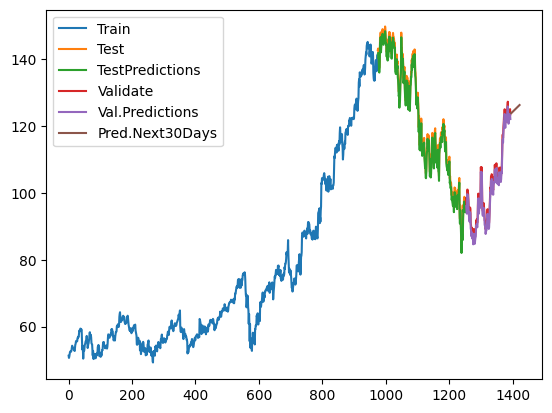

In [48]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, test_forecast_restored['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, val_forecast_restored['Close'])
plt.plot(future_data.index, future_data['Close'])
plt.legend(['Train', 'Test', 'TestPredictions','Validate', 'Val.Predictions', 'Pred.Next30Days'])
plt.show()